In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [ ]:
!pip install tensorflow-datasets==4.3

  Using cached tensorflow_datasets-4.3.0-py3-none-any.whl (3.9 MB)
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.4.0
    Uninstalling tensorflow-datasets-4.4.0:
      Successfully uninstalled tensorflow-datasets-4.4.0


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

In [ ]:
import plotly.express as px

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dataDir = "/content/drive/MyDrive/"

In [ ]:
# movieLenDataPath = dataDir + "movieLensRajUpdated.csv"

In [ ]:
# columns=['unknown', 'Action', 'Adventure','Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir',  'Horror', 'Musical','Mystery', 'Romance','Sci_Fi','Thriller', 'War', 'Western']

# fla32 = ""

# for i in range(len(columns)):
#   fla32 = fla32 + ",tf.float32"

# fla32

In [ ]:
# record_defaults = [tf.float32, tf.float32, tf.float32, tf.float32, tf.string, tf.float32, tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32]

In [ ]:
# dataset = tf.data.experimental.CsvDataset(dataDir + "movieLensRajUpdated.csv",record_defaults,header=True)
# dataset

# DCN

## Load Data

In [ ]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")


In [ ]:
for x in ratings.take(2).as_numpy_iterator():
  print(x)

{'bucketized_user_age': 45.0, 'movie_genres': array([7]), 'movie_id': b'357', 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)", 'raw_user_age': 46.0, 'timestamp': 879024327, 'user_gender': True, 'user_id': b'138', 'user_occupation_label': 4, 'user_occupation_text': b'doctor', 'user_rating': 4.0, 'user_zip_code': b'53211'}
{'bucketized_user_age': 25.0, 'movie_genres': array([ 4, 14]), 'movie_id': b'709', 'movie_title': b'Strictly Ballroom (1992)', 'raw_user_age': 32.0, 'timestamp': 875654590, 'user_gender': True, 'user_id': b'92', 'user_occupation_label': 5, 'user_occupation_text': b'entertainment', 'user_rating': 2.0, 'user_zip_code': b'80525'}


In [ ]:

ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
    "movie_genres": int(x["movie_genres"][0]),
})

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(75_000)
valid = shuffled.skip(75_000).take(10_000)
test = shuffled.skip(85_000).take(15_000)

In [ ]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age","movie_genres"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [ ]:
vocabularies['movie_genres']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19], dtype=int32)

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_valid = valid.batch(4096).cache()
cached_test = test.batch(4096).cache()

## Define Model

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, 
               use_cross_layer, 
               deep_layer_sizes, 
               projection_dim=None, 
               parallel=False):
    super().__init__()

    self.embedding_dimension = 32
    self.parallel = parallel

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age","movie_genres"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    if not self.parallel:
      # Build Cross Network
      if self._cross_layer is not None:
        x = self._cross_layer(x)

      # Build Deep Network
      for deep_layer in self._deep_layers:
        x = deep_layer(x)

      return self._logit_layer(x)
    elif self.parallel and self._cross_layer is not None:
      embed = x
      # Build Cross Network
      cross = self._cross_layer(embed)

      # Build Deep Network
      for deep_layer in self._deep_layers:
        x = deep_layer(x)

      return self._logit_layer(tf.keras.layers.Concatenate()([x, cross]))

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

## Run Model

In [ ]:
def run_models(use_cross_layer, 
               deep_layer_sizes,
               epochs=8,
               learning_rate=0.01, 
               projection_dim=None, 
               num_runs=3, 
               parallel=False):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim,
                parallel=parallel)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    history = model.fit(cached_train, epochs=epochs, validation_data=cached_valid, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv, "history": history}

## Hyperparameter testing func

In [ ]:
def hyperTest(use_cross_layer=True, parallel=True, projection_dim=None):
  epochs = [5, 10, 15, 20]
  learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
  deep_layer_sizes = [[192, 192], [256, 128], [512, 256, 128]]

  best_params = None
  best_metric = 100000
  best_model = None
  params = []
  for epoch in epochs:
    for lr in learning_rates:
      for deep_layer in deep_layer_sizes:
        temp_result = run_models(use_cross_layer, 
                                 deep_layer_sizes=deep_layer, 
                                 parallel=parallel, 
                                 epochs=epoch, 
                                 learning_rate=lr, 
                                 projection_dim=projection_dim)
        param = dict([('epoch', epoch), ('lr', lr), 
                      ('deep_layers', deep_layer), 
                      ('mean', temp_result['mean']), 
                      ('history', temp_result['history'])])
        print(param)
        params.append(param)
        if best_metric > temp_result["mean"]:
          best_metric = temp_result["mean"]
          best_params = param
          best_model = temp_result
  
  return {'best_metric': best_metric, 'best_params': best_params, 'best_model': best_model, 'params': params}

## Hyperparameter Runs

### Parallel Full 

#### Run

In [ ]:
hyper_result = hyperTest()

4/4 [==============================] - 0s 25ms/step - RMSE: 1.0236 - loss: 1.0504 - regularization_loss: 0.0000e+00 - total_loss: 1.0504
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.0221590598424275, 'history': <keras.callbacks.History object at 0x7fd3c9f01590>}
4/4 [==============================] - 0s 26ms/step - RMSE: 1.0138 - loss: 1.0295 - regularization_loss: 0.0000e+00 - total_loss: 1.0295
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.012181540330251, 'history': <keras.callbacks.History object at 0x7fd3c9d37150>}
4/4 [==============================] - 0s 50ms/step - RMSE: 0.9656 - loss: 0.9333 - regularization_loss: 0.0000e+00 - total_loss: 0.9333
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9687006076176962, 'history': <keras.callbacks.History object at 0x7fd3c456c650>}
4/4 [==============================] - 0s 24ms/step - RMSE: 0.9466 - loss: 0.8976 - regularization_loss: 0.0000e+00 - total_loss: 0.8976
{'epoch': 5, 'lr

In [ ]:
#pd.DataFrame.from_dict(hyper_result['params'])[['epoch', 'lr',  'mean', 'deep_layers']]
hyper_result['params']

[{'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9f01590>,
  'lr': 0.001,
  'mean': 1.0221590598424275},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9d37150>,
  'lr': 0.001,
  'mean': 1.012181540330251},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c456c650>,
  'lr': 0.001,
  'mean': 0.9687006076176962},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9e17b90>,
  'lr': 0.005,
  'mean': 0.9446691473325094},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3ca098910>,
  'lr': 0.005,
  'mean': 0.9411833882331848},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3bddf0290>,
  'lr': 0.005,
  'mean': 0.9530825217564901},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c48db350>,
  'lr': 

#### Result

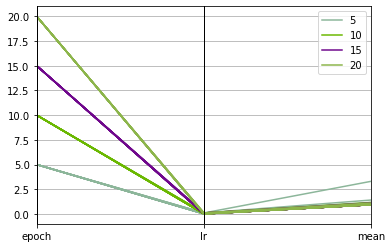

In [ ]:
pd.plotting.parallel_coordinates(pd.DataFrame.from_dict(hyper_result['params'])[['epoch', 'lr',  'mean']], 'epoch', cols=['epoch', 'lr', 'mean'])

In [ ]:
def plotHistory(history):
  rmse = history.history['RMSE']
  val_rmse = history.history['val_RMSE']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(rmse, label='Training RMSE')
  plt.plot(val_rmse, label='Validation RMSE')
  plt.legend(loc='lower right')
  plt.ylabel('RMSE')
  plt.ylim([min(plt.ylim()),2])
  plt.title('Training and Validation RMSE')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Loss')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

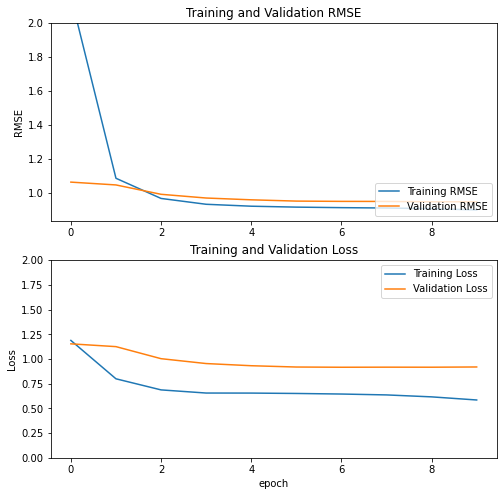

In [ ]:
plotHistory(hyper_result['best_params']['history'])

In [ ]:
df = pd.DataFrame.from_dict(hyper_result['params'])
df['deep_layers'] = [','.join(map(str, l)) for l in df['deep_layers']]

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

### Stacked Full

#### Run

In [ ]:
hyper_result2 = hyperTest(parallel=False)

4/4 [==============================] - 0s 26ms/step - RMSE: 0.9906 - loss: 0.9837 - regularization_loss: 0.0000e+00 - total_loss: 0.9837
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.0068253477414448, 'history': <keras.callbacks.History object at 0x7fd37b6de890>}
4/4 [==============================] - 0s 25ms/step - RMSE: 1.0043 - loss: 1.0120 - regularization_loss: 0.0000e+00 - total_loss: 1.0120
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0044790307680767, 'history': <keras.callbacks.History object at 0x7fd3bdf87110>}
4/4 [==============================] - 0s 47ms/step - RMSE: 0.9816 - loss: 0.9680 - regularization_loss: 0.0000e+00 - total_loss: 0.9680
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.9719915390014648, 'history': <keras.callbacks.History object at 0x7fd38aa397d0>}
4/4 [==============================] - 0s 26ms/step - RMSE: 0.9416 - loss: 0.8885 - regularization_loss: 0.0000e+00 - total_loss: 0.8885
{'epoch': 5, 'l

In [ ]:
hyper_result2

{'best_metric': 0.9292821288108826,
 'best_model': {'history': <keras.callbacks.History at 0x7fd363ce0390>,
  'mean': 0.9292821288108826,
  'model': [<__main__.DCN at 0x7fd3827f3150>,
  'stdv': 0.0020681308133770043},
 'best_params': {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd363ce0390>,
  'lr': 0.005,
  'mean': 0.9292821288108826},
 'params': [{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd37b6de890>,
   'lr': 0.001,
   'mean': 1.0068253477414448},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3bdf87110>,
   'lr': 0.001,
   'mean': 1.0044790307680767},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd38aa397d0>,
   'lr': 0.001,
   'mean': 0.9719915390014648},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd38493f6d0>,
   'lr': 0.005,
   'mean': 0.9500765800

#### Result

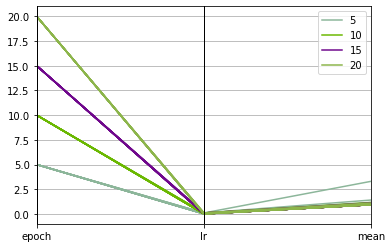

In [ ]:
pd.plotting.parallel_coordinates(pd.DataFrame.from_dict(df)[['epoch', 'lr', 'deep_layers', 'mean']], 'epoch', cols=['epoch', 'lr','mean'])

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result2['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

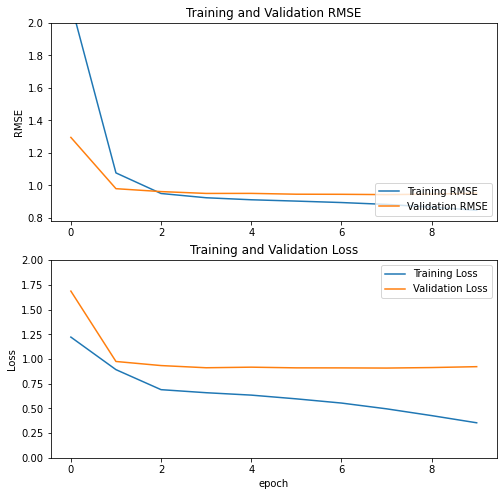

In [ ]:
plotHistory(hyper_result2['best_params']['history'])

### DNN

#### Run

In [ ]:
hyper_result3 = hyperTest(use_cross_layer=False, parallel=False)

4/4 [==============================] - 0s 16ms/step - RMSE: 1.0303 - loss: 1.0643 - regularization_loss: 0.0000e+00 - total_loss: 1.0643
{'epoch': 5, 'lr': 0.001, 'deep_layers': [192, 192], 'mean': 1.0267740885416667, 'history': <keras.callbacks.History object at 0x7fd375373d10>}
4/4 [==============================] - 0s 21ms/step - RMSE: 1.0232 - loss: 1.0517 - regularization_loss: 0.0000e+00 - total_loss: 1.0517
{'epoch': 5, 'lr': 0.001, 'deep_layers': [256, 128], 'mean': 1.0238083998362224, 'history': <keras.callbacks.History object at 0x7fd336bc4210>}
4/4 [==============================] - 0s 39ms/step - RMSE: 0.9723 - loss: 0.9476 - regularization_loss: 0.0000e+00 - total_loss: 0.9476
{'epoch': 5, 'lr': 0.001, 'deep_layers': [512, 256, 128], 'mean': 0.970770021279653, 'history': <keras.callbacks.History object at 0x7fd34f136350>}
4/4 [==============================] - 0s 18ms/step - RMSE: 0.9597 - loss: 0.9218 - regularization_loss: 0.0000e+00 - total_loss: 0.9218
{'epoch': 5, 'lr

In [ ]:
hyper_result3

#### Result

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result3['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

In [ ]:
plotHistory(hyper_result3['best_params']['history'])

### Low Cost Model

#### Run

In [ ]:
hyper_result4 = hyperTest(projection_dim=20)

In [ ]:
hyper_result4

#### Result

In [ ]:
px.parallel_coordinates(pd.DataFrame.from_dict(hyper_result4['params']), color='epoch', color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2).show()

In [ ]:
plotHistory(hyper_result4['best_params']['history'])

In [ ]:
dcn_parallel_result = run_models(use_cross_layer=True,
                                 deep_layer_sizes=[192, 192], 
                                 parallel=True)

In [ ]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

## Feature Importance

### Stacked

In [ ]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

In [ ]:
mat

In [ ]:
block_norm

In [ ]:
dim

### Parallel

In [ ]:
model = dcn_parallel_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

## Result reconstruction




In [ ]:
import ast
import json
import re

### Stack full data read

In [ ]:
stacked_full_raw = """[{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd37b6de890>,
   'lr': 0.001,
   'mean': 1.0068253477414448},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3bdf87110>,
   'lr': 0.001,
   'mean': 1.0044790307680767},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd38aa397d0>,
   'lr': 0.001,
   'mean': 0.9719915390014648},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd38493f6d0>,
   'lr': 0.005,
   'mean': 0.9500765800476074},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd364812110>,
   'lr': 0.005,
   'mean': 0.9476096034049988},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3640c7fd0>,
   'lr': 0.005,
   'mean': 0.9395957191785177},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd35e4f9590>,
   'lr': 0.01,
   'mean': 0.9440789818763733},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd35c463410>,
   'lr': 0.01,
   'mean': 0.943530281384786},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3add10650>,
   'lr': 0.01,
   'mean': 0.9511383374532064},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd37b397690>,
   'lr': 0.05,
   'mean': 2.3072338104248047},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd371dfe950>,
   'lr': 0.05,
   'mean': 2.4179943402608237},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3756ecb10>,
   'lr': 0.05,
   'mean': 3.169251044591268},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd35f682690>,
   'lr': 0.1,
   'mean': 4.000341097513835},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd3529ba5d0>,
   'lr': 0.1,
   'mean': 3.4332024256388345},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7fd34f071750>,
   'lr': 0.1,
   'mean': 4.2116397221883135},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd34cf19050>,
   'lr': 0.001,
   'mean': 0.9385057886441549},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd345e501d0>,
   'lr': 0.001,
   'mean': 0.9382683833440145},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd363cec910>,
   'lr': 0.001,
   'mean': 0.9370369712511698},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd375291610>,
   'lr': 0.005,
   'mean': 0.9312349756558737},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd371ecc110>,
   'lr': 0.005,
   'mean': 0.9304950833320618},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd363ce0390>,
   'lr': 0.005,
   'mean': 0.9292821288108826},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd35f31a990>,
   'lr': 0.01,
   'mean': 0.9325630068778992},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd3524c5d90>,
   'lr': 0.01,
   'mean': 0.9416258931159973},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd34ec89750>,
   'lr': 0.01,
   'mean': 0.9357696374257406},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd342213050>,
   'lr': 0.05,
   'mean': 1.3165883620580037},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd33e920190>,
   'lr': 0.05,
   'mean': 1.3092223405838013},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd361b2e950>,
   'lr': 0.05,
   'mean': 2.4882410764694214},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd37ede3850>,
   'lr': 0.1,
   'mean': 2.205186406771342},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd3752ea350>,
   'lr': 0.1,
   'mean': 3.2450927098592124},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7fd34679f650>,
   'lr': 0.1,
   'mean': 4.016717354456584},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd342e9f6d0>,
   'lr': 0.001,
   'mean': 0.937724749247233},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd34503d3d0>,
   'lr': 0.001,
   'mean': 0.9377471407254537},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd33b128b50>,
   'lr': 0.001,
   'mean': 0.9351488947868347},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd335804850>,
   'lr': 0.005,
   'mean': 0.9322222073872884},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd3347140d0>,
   'lr': 0.005,
   'mean': 0.93573530515035},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd32b5c0cd0>,
   'lr': 0.005,
   'mean': 0.9589069684346517},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd33627cd10>,
   'lr': 0.01,
   'mean': 0.9458406766255697},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd352505ad0>,
   'lr': 0.01,
   'mean': 0.9329789479573568},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd386bc0f50>,
   'lr': 0.01,
   'mean': 0.95781938234965},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd345b54d10>,
   'lr': 0.05,
   'mean': 1.1358832518259685},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd344d00d10>,
   'lr': 0.05,
   'mean': 1.1364626089731853},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd3360efbd0>,
   'lr': 0.05,
   'mean': 2.19323201974233},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd33f4c8810>,
   'lr': 0.1,
   'mean': 2.451796372731527},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd32b185fd0>,
   'lr': 0.1,
   'mean': 2.7945202191670737},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7fd325fc6110>,
   'lr': 0.1,
   'mean': 4.110214551289876},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd324ef5050>,
   'lr': 0.001,
   'mean': 0.9369871020317078},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd3205f1c50>,
   'lr': 0.001,
   'mean': 0.9374988675117493},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd32b2da190>,
   'lr': 0.001,
   'mean': 0.9311750332514445},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd334a20c10>,
   'lr': 0.005,
   'mean': 0.9489561915397644},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd3643cb7d0>,
   'lr': 0.005,
   'mean': 0.9570391972859701},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd324f5a910>,
   'lr': 0.005,
   'mean': 1.0475047032038372},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd32523b9d0>,
   'lr': 0.01,
   'mean': 1.019287606080373},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd33f617810>,
   'lr': 0.01,
   'mean': 1.0009608268737793},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd34687d290>,
   'lr': 0.01,
   'mean': 0.9394557277361552},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd32756b210>,
   'lr': 0.05,
   'mean': 1.0246649781862895},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd31c65e510>,
   'lr': 0.05,
   'mean': 1.122788667678833},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd314d200d0>,
   'lr': 0.05,
   'mean': 1.8860788742701213},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd312c3c690>,
   'lr': 0.1,
   'mean': 2.032305439313253},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd30eac4490>,
   'lr': 0.1,
   'mean': 1.9077619711558025},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7fd32b2b6f50>,
   'lr': 0.1,
   'mean': 3.8367648124694824}]"""

### Parallel data read

In [ ]:
parallel_full_raw = """
[{'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9f01590>,
  'lr': 0.001,
  'mean': 1.0221590598424275},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9d37150>,
  'lr': 0.001,
  'mean': 1.012181540330251},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c456c650>,
  'lr': 0.001,
  'mean': 0.9687006076176962},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c9e17b90>,
  'lr': 0.005,
  'mean': 0.9446691473325094},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3ca098910>,
  'lr': 0.005,
  'mean': 0.9411833882331848},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3bddf0290>,
  'lr': 0.005,
  'mean': 0.9530825217564901},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c48db350>,
  'lr': 0.01,
  'mean': 0.9409758845965067},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3caebb210>,
  'lr': 0.01,
  'mean': 0.948725422223409},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3b46e4b10>,
  'lr': 0.01,
  'mean': 0.9610867698987325},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3b0e00510>,
  'lr': 0.05,
  'mean': 0.975243091583252},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3be0a1110>,
  'lr': 0.05,
  'mean': 0.9767937064170837},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c4ad3510>,
  'lr': 0.05,
  'mean': 1.06205948193868},
 {'deep_layers': [192, 192],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3afca2310>,
  'lr': 0.1,
  'mean': 1.1753754218419392},
 {'deep_layers': [256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3c4905cd0>,
  'lr': 0.1,
  'mean': 1.4086823066075642},
 {'deep_layers': [512, 256, 128],
  'epoch': 5,
  'history': <keras.callbacks.History at 0x7fd3b499d3d0>,
  'lr': 0.1,
  'mean': 3.3041347662607827},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3b0f45510>,
  'lr': 0.001,
  'mean': 0.9387390414873759},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3a50bc050>,
  'lr': 0.001,
  'mean': 0.9391554792722067},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3b4bc4850>,
  'lr': 0.001,
  'mean': 0.9379464189211527},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3ca103110>,
  'lr': 0.005,
  'mean': 0.937194307645162},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3aae0d050>,
  'lr': 0.005,
  'mean': 0.9375969568888346},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3a0c8b150>,
  'lr': 0.005,
  'mean': 0.9333707292874655},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3ba5cd210>,
  'lr': 0.01,
  'mean': 0.9325208067893982},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3cb3394d0>,
  'lr': 0.01,
  'mean': 0.930410106976827},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3c4a28650>,
  'lr': 0.01,
  'mean': 0.9363988041877747},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3a62de590>,
  'lr': 0.05,
  'mean': 0.938744306564331},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd39a5314d0>,
  'lr': 0.05,
  'mean': 0.9418856302897135},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3be1a0490>,
  'lr': 0.05,
  'mean': 0.9547218879063925},
 {'deep_layers': [192, 192],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3b12b1710>,
  'lr': 0.1,
  'mean': 0.9504110217094421},
 {'deep_layers': [256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3aafb4090>,
  'lr': 0.1,
  'mean': 0.9676990509033203},
 {'deep_layers': [512, 256, 128],
  'epoch': 10,
  'history': <keras.callbacks.History at 0x7fd3960d58d0>,
  'lr': 0.1,
  'mean': 1.1512500445048015},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3ae39d350>,
  'lr': 0.001,
  'mean': 0.93791796763738},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3ba8b4610>,
  'lr': 0.001,
  'mean': 0.9380526741345724},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3baa19690>,
  'lr': 0.001,
  'mean': 0.937795619169871},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd396a6d590>,
  'lr': 0.005,
  'mean': 0.9336661497751871},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3adbd0b50>,
  'lr': 0.005,
  'mean': 0.9342485467592875},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd38d84d9d0>,
  'lr': 0.005,
  'mean': 0.9317109982172648},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3b82db450>,
  'lr': 0.01,
  'mean': 0.9362539251645406},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3bee89a10>,
  'lr': 0.01,
  'mean': 0.9388208587964376},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3922f5a90>,
  'lr': 0.01,
  'mean': 0.933372974395752},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3addd1050>,
  'lr': 0.05,
  'mean': 0.9386670390764872},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3878f4410>,
  'lr': 0.05,
  'mean': 0.9704810976982117},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd384027290>,
  'lr': 0.05,
  'mean': 0.9402044812838236},
 {'deep_layers': [192, 192],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3bee6df50>,
  'lr': 0.1,
  'mean': 0.9461522499720255},
 {'deep_layers': [256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd3c46c5890>,
  'lr': 0.1,
  'mean': 0.9459749062856039},
 {'deep_layers': [512, 256, 128],
  'epoch': 15,
  'history': <keras.callbacks.History at 0x7fd39955e190>,
  'lr': 0.1,
  'mean': 1.1111133893330891},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd395c94490>,
  'lr': 0.001,
  'mean': 0.9384387532869974},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd3826cb9d0>,
  'lr': 0.001,
  'mean': 0.9384556412696838},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37ed84090>,
  'lr': 0.001,
  'mean': 0.9367409547170004},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd3adda9850>,
  'lr': 0.005,
  'mean': 0.9304507573445638},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd3bab22150>,
  'lr': 0.005,
  'mean': 0.9338253736495972},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd386e54b10>,
  'lr': 0.005,
  'mean': 0.9370338320732117},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd389d50d90>,
  'lr': 0.01,
  'mean': 0.9614124298095703},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37d0ba6d0>,
  'lr': 0.01,
  'mean': 0.9563449819882711},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37b2ea950>,
  'lr': 0.01,
  'mean': 0.9637242754300436},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37538ef90>,
  'lr': 0.05,
  'mean': 0.9652019937833151},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd3a838ded0>,
  'lr': 0.05,
  'mean': 0.9839632511138916},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37f09c850>,
  'lr': 0.05,
  'mean': 0.9398621320724487},
 {'deep_layers': [192, 192],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37f0ac650>,
  'lr': 0.1,
  'mean': 0.9456515510876974},
 {'deep_layers': [256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37ee7f790>,
  'lr': 0.1,
  'mean': 0.9482931693394979},
 {'deep_layers': [512, 256, 128],
  'epoch': 20,
  'history': <keras.callbacks.History at 0x7fd37d20b6d0>,
  'lr': 0.1,
  'mean': 1.10321048895518}]"""

### DNN RAW Read

In [ ]:
dnn_raw = """
"""

### Stacked low read

In [ ]:
stacked_low_raw = """[{'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c6e8f7450>,
   'lr': 0.001,
   'mean': 1.000368058681488},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c94620690>,
   'lr': 0.001,
   'mean': 1.0008159677187602},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6ca6f578d0>,
   'lr': 0.001,
   'mean': 0.9692723949750265},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c63ba7650>,
   'lr': 0.005,
   'mean': 0.9389805793762207},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c3dad90d0>,
   'lr': 0.005,
   'mean': 0.9399542808532715},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c0fd0a1d0>,
   'lr': 0.005,
   'mean': 0.9507050712903341},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf7aa89d0>,
   'lr': 0.01,
   'mean': 0.9489022095998129},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf78b1a10>,
   'lr': 0.01,
   'mean': 0.944469153881073},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c096cc650>,
   'lr': 0.01,
   'mean': 0.9467695554097494},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c0908f050>,
   'lr': 0.05,
   'mean': 0.967252254486084},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf79f8810>,
   'lr': 0.05,
   'mean': 0.9676798184712728},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6c020b6090>,
   'lr': 0.05,
   'mean': 1.0815852483113606},
  {'deep_layers': [192, 192],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6bf6879550>,
   'lr': 0.1,
   'mean': 1.5494410196940105},
  {'deep_layers': [256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6be922e850>,
   'lr': 0.1,
   'mean': 1.1817898750305176},
  {'deep_layers': [512, 256, 128],
   'epoch': 5,
   'history': <keras.callbacks.History at 0x7f6be715f990>,
   'lr': 0.1,
   'mean': 2.379037102063497},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be2ff7110>,
   'lr': 0.001,
   'mean': 0.9389605522155762},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bdc7b0350>,
   'lr': 0.001,
   'mean': 0.939000646273295},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bd8ede050>,
   'lr': 0.001,
   'mean': 0.9384143153826395},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be114c250>,
   'lr': 0.005,
   'mean': 0.9371030926704407},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bd1e32310>,
   'lr': 0.005,
   'mean': 0.9386645158131918},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c18055750>,
   'lr': 0.005,
   'mean': 0.9375331799189249},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6cc731dc50>,
   'lr': 0.01,
   'mean': 0.9346014857292175},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bfeb67750>,
   'lr': 0.01,
   'mean': 0.933172345161438},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c5c9d3090>,
   'lr': 0.01,
   'mean': 0.940509299437205},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c6cab4150>,
   'lr': 0.05,
   'mean': 0.9477801521619161},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c20aa15d0>,
   'lr': 0.05,
   'mean': 0.9418696959813436},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6c332e8a50>,
   'lr': 0.05,
   'mean': 0.9716687401135763},
  {'deep_layers': [192, 192],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be73c1150>,
   'lr': 0.1,
   'mean': 0.9527191519737244},
  {'deep_layers': [256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6be7725090>,
   'lr': 0.1,
   'mean': 0.9739111264546713},
  {'deep_layers': [512, 256, 128],
   'epoch': 10,
   'history': <keras.callbacks.History at 0x7f6bf7e779d0>,
   'lr': 0.1,
   'mean': 1.1295245091120403},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6be963e4d0>,
   'lr': 0.001,
   'mean': 0.938054084777832},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bdd3e8090>,
   'lr': 0.001,
   'mean': 0.9380642970403036},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bed1a6a50>,
   'lr': 0.001,
   'mean': 0.9378294746081034},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c9a13ac90>,
   'lr': 0.005,
   'mean': 0.9340311090151469},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bdb300290>,
   'lr': 0.005,
   'mean': 0.934217115243276},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bce2576d0>,
   'lr': 0.005,
   'mean': 0.9417093793551127},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bca9e9190>,
   'lr': 0.01,
   'mean': 0.9471367001533508},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bc7167090>,
   'lr': 0.01,
   'mean': 0.9355885982513428},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bc3899110>,
   'lr': 0.01,
   'mean': 0.9622859756151835},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbffef1d0>,
   'lr': 0.05,
   'mean': 0.9431696534156799},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbe72f790>,
   'lr': 0.05,
   'mean': 0.9473694562911987},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bb9663110>,
   'lr': 0.05,
   'mean': 0.9405649900436401},
  {'deep_layers': [192, 192],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6bbe80d5d0>,
   'lr': 0.1,
   'mean': 0.9493876695632935},
  {'deep_layers': [256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6c4370ef50>,
   'lr': 0.1,
   'mean': 0.9538472096125284},
  {'deep_layers': [512, 256, 128],
   'epoch': 15,
   'history': <keras.callbacks.History at 0x7f6ca8678a10>,
   'lr': 0.1,
   'mean': 1.1180118719736736},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c49202910>,
   'lr': 0.001,
   'mean': 0.9385871887207031},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c6760e910>,
   'lr': 0.001,
   'mean': 0.9385058085123698},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf7869790>,
   'lr': 0.001,
   'mean': 0.9369035760561625},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c022bff10>,
   'lr': 0.005,
   'mean': 0.9400285879770914},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bf0818f50>,
   'lr': 0.005,
   'mean': 0.9381002982457479},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bc9f17590>,
   'lr': 0.005,
   'mean': 0.9504168430964152},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bed7032d0>,
   'lr': 0.01,
   'mean': 0.9682369828224182},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6c1b8672d0>,
   'lr': 0.01,
   'mean': 0.9452779293060303},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bfeb1b250>,
   'lr': 0.01,
   'mean': 0.9603259960810343},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bdb51a450>,
   'lr': 0.05,
   'mean': 0.9489754438400269},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6be16445d0>,
   'lr': 0.05,
   'mean': 0.9694866339365641},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bdaf96a50>,
   'lr': 0.05,
   'mean': 0.9421877463658651},
  {'deep_layers': [192, 192],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bb6cac310>,
   'lr': 0.1,
   'mean': 0.9470345179239908},
  {'deep_layers': [256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bb0aaa290>,
   'lr': 0.1,
   'mean': 0.9497267603874207},
  {'deep_layers': [512, 256, 128],
   'epoch': 20,
   'history': <keras.callbacks.History at 0x7f6bae9db590>,
   'lr': 0.1,
   'mean': 1.0898589293162029}]"""

### Raw data

### Stacked Full

In [ ]:
layer_mapping = {}
for i, layer in enumerate(set(stacked_full_df['deep_layers'])):
  layer_mapping[layer] = i

In [ ]:
stacked_full_list = ast.literal_eval(stacked_full_raw)
stacked_full_df = pd.DataFrame(stacked_full_list)
stacked_full_df['deep_layers'] = [','.join(map(str, l)) for l in stacked_full_df['deep_layers']]
stacked_full_df['mapped_layer_type'] = [layer_mapping[layer] for layer in stacked_full_df['deep_layers']]

In [ ]:
fig = px.parallel_categories(stacked_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                             dimensions=['epoch', 'lr', 'mapped_layer_type'],
                color='mean',  color_continuous_scale=px.colors.sequential.Inferno,
                labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'})
fig.show()

In [ ]:
px.parallel_coordinates(stacked_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

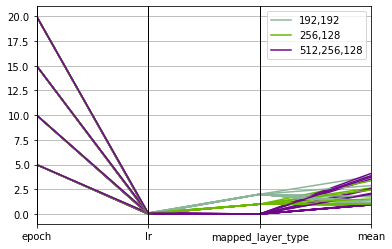

In [ ]:
pd.plotting.parallel_coordinates(stacked_full_df[['deep_layers', 'epoch', 'lr', 'mapped_layer_type', 'mean']], 
                                 'deep_layers', 
                                 cols=['epoch', 'lr', 'mapped_layer_type', 'mean'])

### Parallel Full

In [ ]:
parallel_full_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', parallel_full_raw))
parallel_full_df = pd.DataFrame(parallel_full_list)
parallel_full_df['deep_layers'] = [','.join(map(str, l)) for l in parallel_full_df['deep_layers']]
parallel_full_df['mapped_layer_type'] = [layer_mapping[layer] for layer in parallel_full_df['deep_layers']]

In [ ]:
px.parallel_coordinates(parallel_full_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

### DNN

In [ ]:
dnn_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', dnn_raw))
dnn_df = pd.DataFrame(dnn_list)
dnn_df['deep_layers'] = [','.join(map(str, l)) for l in dnn_df['deep_layers']]
dnn_df['mapped_layer_type'] = [layer_mapping[layer] for layer in dnn_df['deep_layers']]

In [ ]:
px.parallel_coordinates(dnn_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

### Stacked Low Cost

In [ ]:
stacked_low_list = ast.literal_eval(re.sub("\'history\'\: \<(.*?)\>,", '', stacked_low_raw))
stacked_low_df = pd.DataFrame(stacked_low_list)
stacked_low_df['deep_layers'] = [','.join(map(str, l)) for l in stacked_low_df['deep_layers']]
stacked_low_df['mapped_layer_type'] = [layer_mapping[layer] for layer in stacked_low_df['deep_layers']]

In [ ]:
px.parallel_coordinates(stacked_low_df[['epoch', 'lr', 'mapped_layer_type', 'mean']], 
                        color='mean', 
                        labels={'epoch': 'Epochs', 'lr': 'Learning Rate', 'mapped_layer_type': 'Deep layer Type', 'mean': 'RMSE'},
                        color_continuous_scale=px.colors.diverging.Tealrose, 
                        color_continuous_midpoint=2).show()

# DCN v2